# Introduction

Since Airbnb was founded in 2008, it has changed the hospitality and rental industry. Airbnb offers travellers from all over the world a fast and efficient way to search for long and short-term accomodations, as well as helping hosts to advertise to a much bigger audience. Given the reach and profitability of this venture, in this paper I found it interesting to explore the factors affecting the price of an Airbnb listing. By looking at the location of the listing, the type of accomodation the listing is offering (i.e. shared room or entire house), the number of days it is available, the number of reviews the listing has and other factors, I was able to explore different regression models to predict the price of the listing. The models that are explored in this paper are Decision Trees, Random Forest and a Multi-Layer Perceptron. To ensure that the results are replicable and there is no data leakage, k-fold cross validation was also performed using a Random Forest model. 

### Importing libaries and dataset

In [259]:
import numpy as np
import pandas as pd
import math

# encoding categorical variables
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# model building
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# for k-fold validation
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

# Importing dataset
df = pd.read_csv('AB_US_2020.csv')
# dropping neighbourhood group as it has many missing values
df = df.drop('neighbourhood_group', axis=1)

# Exploratory Data Analysis

### Dataset

The dataset used is from an open task on Kaggle, called "U.S Airbnb Open Data".[^1] It was compiled by Kritik Seth from multiple datasets found on "Inside Airbnb". [^2] It contains 226030 rows and 17 columns. Each row represents an unique Airbnb listing. All of the listings shown are constrained to the U.S only. The description of the columns are as follows:

[^1]: https://www.kaggle.com/kritikseth/us-airbnb-open-data
[^2]: http://insideairbnb.com/index.html


| Column Name                    | Description                                              | Number of missing values |
|--------------------------------|----------------------------------------------------------|--------------------------|
| id                             | unique listing id                                        | 0                        |
| name                           | name of listing                                          | 28                       |
| host_id                        | unique host id                                           | 0                        |
| host_name                      | name of host                                             | 33                       |
| neighbourhood_group            | group in which the neighbourhood lies                    | 115845                   |
| neighbourhood                  | name of the neighbourhood                                | 0                        |
| latitude                       | latitude of listing                                      | 0                        |
| longitude                      | longitude of listing                                     | 0                        |
| room_type                      | type of room (Private, Shared, Entire home/apt, Rental)  | 0                        |
| price                          | price of listing per night                               | 0                        |
| minimum_nights                 | minimum number of nights required to book                | 0                        |
| number_of_reviews              | total number of reviews on listing                       | 0                        |
| last_review                    | date on which listing received its last review           | 48602                    |
| reviews_per_month              | average reviews per month on listing                     | 48602                    |
| calculated_host_listings_count | total number of listings by host                         | 0                        |
| availability_365               | number of days in year the listing is available for rent | 0                        |
| city                           | region of the listing                                    | 0                        |

### Previous Work

There has been multiple notebooks posted on this particular dataset. The most highly rated notebooks have all been on natural language processing. They have used the "name" column, which is a highly descriptive title for the listing, to predict the price of the listing. 

The highest rated notebook [^1] has used an ensemble of models containing random forest model and sequential neural network. The sequential neural network used an embedding layer which used the 'name' of the listing to predict price using ReLu as the activation function. This gave an RMSE of 31 USD. The random forest model took advantage of the numerical features in the dataset, giving an RMSE of 12 USD. Altogether, the notebook has managed to achieve a root-mean-squared-error of 20, which means the predicted prices from the model are +/- USD 20 than the actual prices. However, there are two points of note about this analysis: it uses approximately 25% of the data by removing a large number of outliers and does not perform any cross-validation techniques, although the author addresses overfitting by saying that overfitting is not prevalent due to the degree of heteroskedasticity being small. 

In contrast, the second highest rated notebook [^2] uses the columns: 'neighbourhood_group','room_type', 'city', 'name', 'host_name', 'neighbourhood' to predict price. Through the use of a word tokenizer, they analyze the 'name' column and use it in their linear regression and random forest regressor models. They were able to achieve an RMSE of 0.04 through their random forest model, however, they do not use any cross-validation techniques, which calls into question the possibility of data leakage. It is also uncertain how much outlier amputation took place during data analysis.

[^1]: https://www.kaggle.com/thomaskonstantin/u-s-airbnb-analysis-and-price-prediction
[^2]: https://www.kaggle.com/ojaswagarg/nlp-to-get-over-90-regression-score

### Data Analysis

##### Heatmap showing correlation between numerical variables

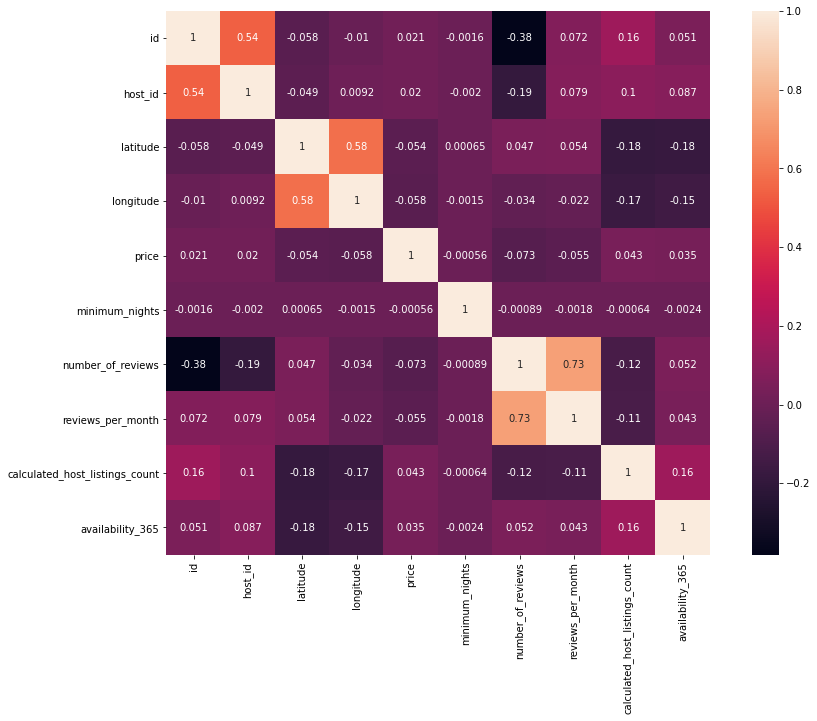

In [33]:
# citation 3
corrmat = df.corr()
corrmat.head()
fig = plt.figure(figsize = (15,10))
sns.heatmap(corrmat,square = True,annot = True)
plt.show()

Firstly, I explored the correlation of the variables in the dataset to each other. As expected, longitude and latitude have some correlation, as well as number_of_reviews and reviews_per_month. Therefore, I would use either of those variables but not both and since reviews_per_month has a lot of missing values, it is more preferable to use number_of_reviews. The variables calculated_host_listings_count and availability_365 have slight correlation to each other, however, they are also both correlated to price.

##### Distribution of numerical variables

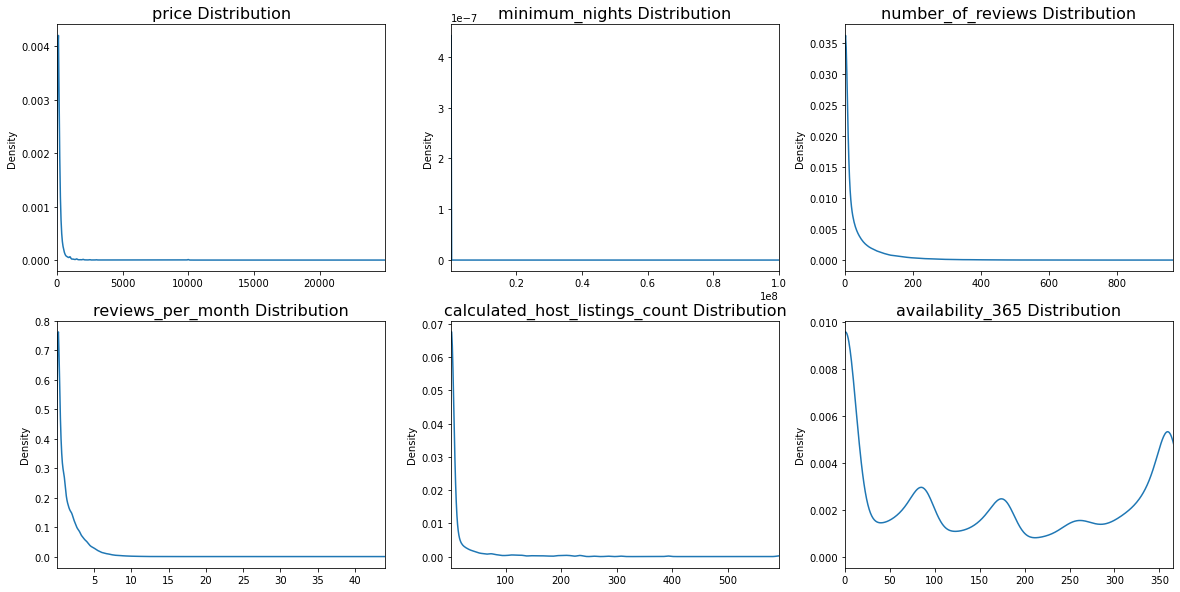

In [4]:
# citation 2
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(20)
numerical_variables = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
current_var = 0
for row in axes:
    for col in row:
        voi = numerical_variables[current_var] # variable of interest
        df[voi].plot(kind='kde', ax=col, xlim=(min(df[voi]), max(df[voi])))
        col.set_title(voi +' Distribution', fontsize=16)
        current_var += 1

| Column Name                    | Mean | Standard Deviation | 75% Quantile   | Max       |
|--------------------------------|------|--------------------|----------------|-----------|
| price                          | 220  | 570                | 201            | 25000     |
| minimum_nights                 | 453  | 210000             | 7             | 100000000 |
| number_of_reviews              | 34.5 | 63.6               | 39             | 966       |
| reviews_per_month              | 1.43 | 1.68               | 2.06           | 44.1      |
| calculated_host_listings_count | 16.7 | 51.1               | 6              | 593       |
| availability_365               | 159  | 140                | 311            | 365       |

Next, I looked the distributions of the numerical variables by plotting them from their minimum to maximum values. The price has most of its observations in between 0-500 USD (93%), but has a max value of 25000, showing that there is a big left skew in our outcome variable. This is also present in number_of_reviews, where our 75% quantile is 39, while our max value is 966, showing that most of our datapoints are in the lower range (0-39). We can also see this in calculated_host_listings_count, where the 75% quantile is 6, while the max value is 593. The minimum_nights variable contains an observation in the millions, which means there is some improbable or fault data points in this dataset. Therefore it can be said that all of these variables contain massive outliers (datapoints more than 2 standard deviations from the mean).  The availability_365 variable seems to be multi-modal, but the values are inbetween 0 and 365, which means there are no outliers in this column. Due to the significant correlation between number_of_reviews and reviews_per_month, only number_of_reviews will be used in modelling.

In [260]:
# transforming object columns to category
df['city'] = df['city'].astype('category')
df['room_type'] = df['room_type'].astype('category')
df['neighbourhood'] = df['neighbourhood'].astype('category')

In [ ]:
# plotting price across room types
sns.catplot(x='room_type', y='price', kind='box', data=df)

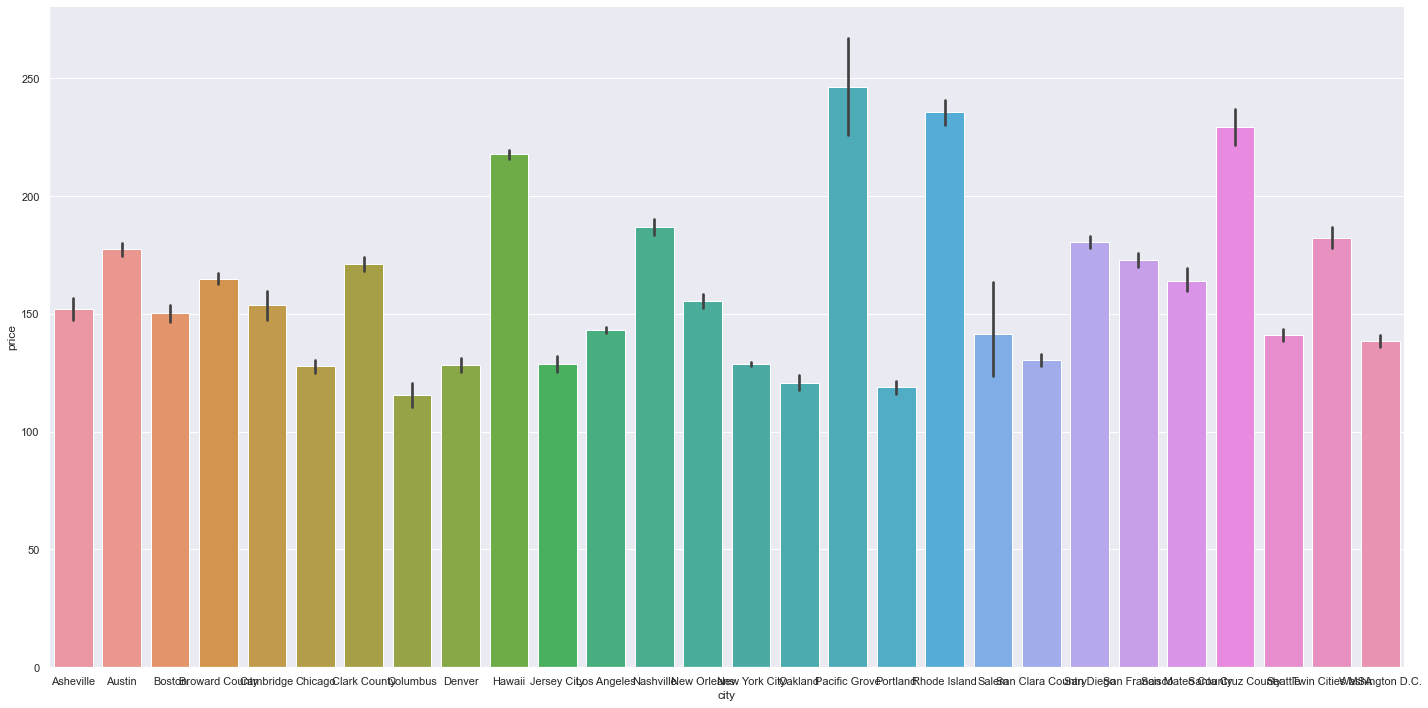

In [123]:
sns.catplot(x='city', y='price', aspect=2, height=10, legend = True, kind='bar', data=df )

| Room_type              | Percentage of data |
|------------------------|--------------------|
| Entire house/apartment  | 68%                |
| Private room           | 29%                |
| Other (shared, rental) | 3%                 |


In order to further explore the outliers in the price variable, I decided to look at the distribution across room_types. The listings with the highest prices are the ones offering the entire home or apartment, which accounts for the high prices of the listing, since there are multiple listings above 10000 for the entire home or apartment category. Since 68% of the dataset has listings that offer entire house, it seems appropiate that 7% of the dataset (roughly 11,000 datapoints) are priced at more than 500 USD per night, since there will some houses that are extremely expensive to rent and may be able to house a large number of people.

|   Name of city | Percentage of data |
|---------------:|-------------------:|
|  New York City |              20.73 |
|    Los Angeles |              13.87 |
|         Hawaii |               9.72 |
|      San Diego |               5.40 |
| Broward County |               4.76 |
|         Austin |               4.52 |
|   Clark County |               3.75 |
|         Others |               37.5 |

Another indicator of price in listings could be the location or city of the listing. 44% of the dataset are in New York City, Los Angeles and Hawaii, which are high-priced, competitive real-estate markets with large vacation homes for the rich. As seen in the barplot above, the highest priced listings are in Pacific Grove, a neighbourhood in California where real-estate prices are notoriously high (which may account for some of the outliers in price).

##### Removing Outliers

By calculating the mean and standard deviation of each column that had outliers, I removed datapoints that were more than 1 s.d. away from the mean. By doing this for each column, I dropped 4% of the dataset, which means there was a significant amount of the data left to run modelling on. 

In [261]:
# removing outliers from price
price = df['price'].tolist()
mean, std = np.mean(price), np.std(price)
cutoff = mean+std
df_o = df.loc[df['price'] <= cutoff]

# removing outliers from minimum_nights
df_o['minimum_nights'].tolist()
mean, std = np.mean(price), np.std(price)
cutoff = mean+std
df_o = df_o.loc[df_o['minimum_nights'] <= cutoff]

# removing outliers from number_of_reviews
df_o['number_of_reviews'].tolist()
mean, std = np.mean(price), np.std(price)
cutoff = mean+std
df_o = df_o.loc[df_o['number_of_reviews'] <= cutoff]

# removing outliers from calculated_host_listings_count
df_o['calculated_host_listings_count'].tolist()
mean, std = np.mean(price), np.std(price)
cutoff = mean+std
df_o = df_o.loc[df_o['calculated_host_listings_count'] <= cutoff]

# percentage of dataset left
print("After removing outliers from several columns, the percentage of the original dataset left is", 100 * len(df_o)/len(df), "%")

# reassigning df
df = df_o

After removing outliers from several columns, the percentage of the original dataset left is 96.48188293589347 %


##### Distribution after outlier removal

In order to ensure that our data is more normally distributed after outlier removal, I looked at their distributions after the removal of outliers.

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(20)
numerical_variables = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
current_var = 0
for row in axes:
    for col in row:
        voi = numerical_variables[current_var] # variable of interest
        df[voi].plot(kind='kde', ax=col, xlim=(min(df[voi]), max(df[voi])))
        col.set_title(voi +' Distribution', fontsize=16)
        current_var += 1

In [ ]:
# plotting price across room types
sns.catplot(x='room_type', y='price', kind='box', data=df)

In [ ]:
sns.catplot(x='city', y='price', aspect=2, height=10, legend = True, kind='bar', data=df )

##### Encoding for categorical variables

Since we have multiple object variables that can be defined as categories in this dataset, such as room_type, neighbourhood and city, these should be used in modelling since it may be effective in improving predictive power. Room_type has 4 categories: Private room, Shared room, Entire home/apt, Rental. There are 28 cities in this dataset and over 1000 neighbourhoods. Since room_type and city have lower number of categories one-hot encoding was used to transform this variable into numerical data that can be used in a model. One-hot encoding creates new columns indicating the presence (or absence) of each possible value in the original data. Label encoding is used for the neighbourhoods variable since it has a high number of categories and therefore would introduce too many features in the dataset. Label encoding assumes an ordering of the categories while one-hot encoding does not.

In [262]:
# one-hot encoding for room_type
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoded_room_type = OH_encoder.fit_transform(df[['room_type']])
encoded_room_type = pd.DataFrame(encoded_room_type)

# label encoding for neighbourhood
label_encoder = LabelEncoder()
encoded_neighborhood = label_encoder.fit_transform(df[['neighbourhood']])

# one-hot encoding for room_type
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoded_city = OH_encoder.fit_transform(df[['city']])
encoded_city = pd.DataFrame(encoded_city)

# Modelling

The models that I explored are Decision Trees, Random Forest and Multi-Layer Perceptron. Since my outcome variable (price) was continuous, I used the regressor version of these models. I used Decision Tree as a baseline model to understand 

In [263]:
# our features and independant variables
feature_list = ['minimum_nights', 'number_of_reviews', 'calculated_host_listings_count' ,'availability_365']
X = df[feature_list]
y = df['price']

# Add categorical columns to numerical features
X = X.reset_index() # without resetting index, pd.concat will produce NaN values
X = X.drop(labels=['index'],axis=1)
X['encoded_neighborhood']= encoded_neighborhood.tolist()

# adding encoded room_type
X = pd.concat([X, encoded_room_type], axis=1)
X['Entire home/apt'] = X[0]
X['Private room'] = X[1]
X['Shared room'] = X[2]
X['Hotel room'] = X[3]
for col in [0,1,2,3]:
    X = X.drop(labels=col, axis=1)

# adding encoded city
X = pd.concat([X, encoded_city], axis=1)

# splitting into training and testing sets
train_X, valid_X, train_y, valid_y = train_test_split(X, y, random_state = 1)
mlp_train_X, mlp_valid_X, mlp_train_y, mlp_valid_y = train_test_split(X, y, random_state = 1)
X.head()

,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,encoded_neighborhood,Entire home/apt,Private room,Shared room,Hotel room,0,...,18,19,20,21,22,23,24,25,26,27
0,1,138,1,0,5,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,114,11,288,3,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,30,89,2,298,3,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,267,5,0,7,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,30,58,1,0,3,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Decision Tree Regressor [^1]

Decision Trees are predictive models that arrive at an estimate by asking a series of questions to the data, each question narrowing the possible values until the model get confident enough to make a single prediction. 

Decision trees start from a root node and then splits into branches (also known as edges), which then link to leaves (aka nodes) which form decision points. The decision tree regressor uses mean-squared-error to decide when to split a node into two or more sub-nodes. A final decision is reached when a leaf no longer generates any new branches and results in a terminal node. This is decided by setting the hyper-parameters, such as stopping when max_depth limit is reached or no splitting is possible for the (terminal) nodes.

[^1]: https://gdcoder.com/decision-tree-regressor-explained-in-depth/

In [234]:
# model building
model = DecisionTreeRegressor(random_state=1)
model.fit(train_X,train_y)

# model predictions
dt_predictions = model.predict(valid_X)
dt_rmse = mean_squared_error(valid_y, dt_predictions, squared=False)
print("RMSE for Decision Tree: ", dt_rmse)

RMSE for Decision Tree:  134.20193177557618


In order to optimize our Decision Tree model, we can set a stopping criteria: the number of max_leaf_nodes. This means that the algorithm will stop building the tree when it reaches a specific number of terminal nodes (nodes which have no splitting) and produce the prediction. The number of leaves that gave the lowest RMSE was in the range of 500-700, therefore I used 500 nodes to predict using Decision Trees later. The best RMSE produced by the Decision Tree model is 103 USD.

In [235]:
# citation 1
# finding the optimal max_leaf_node
def get_rmse(max_leaf_nodes):
    # model building
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=1)
    model.fit(train_X, train_y)

    # model predictions
    dt_predictions = model.predict(valid_X)
    rmse = mean_squared_error(valid_y, dt_predictions, squared=False)
    return(rmse)

# compare RMSE with differing values of max_leaf_nodes
for max_leaf_nodes in [50, 100, 500, 700, 800, 1000, 1500]:
    my_rmse = get_rmse(max_leaf_nodes)
    print("Max leaf nodes: %d  \t\t Root Mean Squared Error:  %d" %(max_leaf_nodes, my_rmse))

Max leaf nodes: 50  		 Root Mean Squared Error:  107
Max leaf nodes: 100  		 Root Mean Squared Error:  105
Max leaf nodes: 500  		 Root Mean Squared Error:  103
Max leaf nodes: 700  		 Root Mean Squared Error:  103
Max leaf nodes: 800  		 Root Mean Squared Error:  103
Max leaf nodes: 1000  		 Root Mean Squared Error:  103
Max leaf nodes: 1500  		 Root Mean Squared Error:  104


##### Recursive Feature Elimination [^1]

Recursive feature elimination is a method by which we can select features that are most effective at predicting the outcome variable. Since we currently have 37 features after adding in our one-hot encoded categorical variables, through RFE we can decrease the number of features that are actually the most useful at predicting price, thus decreasing computational time and increasing performance, since more features may result in worse predictive power of the model. 

I used the RFE from scikit-learn library. RFE is a wrapper-style feature-selection function. This means that a different machine learning algorithm is given and used in the core of the method, is wrapped by RFE, and used to help select features. This is in contrast to filter-based feature selections that score each feature and select those features with the largest (or smallest) score. 

RFE also uses filter-based feature selection internally. It works by searching for a subset of features by starting with all features in the training dataset and successfully removing features until the desired number remains.This is achieved by fitting the given machine learning algorithm used in the core of the model, ranking features by importance, discarding the least important features, and re-fitting the model. This process is repeated until a specified number of features remains. 

The hyperparameters of RFE are the choice of base algorithm and the number of features selected. I have tried hyperparameter tuning with RFE but due to the size of the dataset, it was not possible to run any models more computationally expensive than linear regression or decision tree (such as random forest). Between a linear regression model and a decision tree, the decision tree provides a better RMSE, therfore it was used for prediction. For the number of features hyperparameter, I manually tried the selection of 5, 10 and 15 features. The best number of features proved to be 10, which gave the lowest RMSE.

[^1]: https://machinelearningmastery.com/rfe-feature-selection-in-python/

In [264]:
# create pipeline of models using rfe and dt
rfe = RFE(estimator= DecisionTreeRegressor(max_leaf_nodes=500), n_features_to_select=10)
model = DecisionTreeRegressor(max_leaf_nodes=500)
pipeline = Pipeline(steps=[('s',rfe),('m',model)])

# using k-fold cross validation to evaluate the model pipeline
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')

print('RMSE for RFE: ', math.sqrt(-1 * n_scores.mean()))

In [265]:
# rfe to find feature importance
rfe.fit(train_X, train_y)

features_to_drop = []
for i in range(train_X.shape[1]):
    if (not rfe.support_[i] and rfe.ranking_[i] > 10.0):
        features_to_drop.append(train_X.columns[i])
    print('Column: %s, Selected %s, Rank: %.3f' % (train_X.columns[i], rfe.support_[i], rfe.ranking_[i]))

Column: minimum_nights, Selected True, Rank: 1.000
Column: number_of_reviews, Selected True, Rank: 1.000
Column: calculated_host_listings_count, Selected True, Rank: 1.000
Column: availability_365, Selected True, Rank: 1.000
Column: encoded_neighborhood, Selected True, Rank: 1.000
Column: Entire home/apt, Selected True, Rank: 1.000
Column: Private room, Selected True, Rank: 1.000
Column: Shared room, Selected False, Rank: 22.000
Column: Hotel room, Selected False, Rank: 5.000
Column: 0, Selected False, Rank: 21.000
Column: 1, Selected False, Rank: 15.000
Column: 2, Selected False, Rank: 16.000
Column: 3, Selected False, Rank: 2.000
Column: 4, Selected False, Rank: 9.000
Column: 5, Selected False, Rank: 10.000
Column: 6, Selected False, Rank: 6.000
Column: 7, Selected False, Rank: 23.000
Column: 8, Selected False, Rank: 14.000
Column: 9, Selected True, Rank: 1.000
Column: 10, Selected False, Rank: 8.000
Column: 11, Selected True, Rank: 1.000
Column: 12, Selected False, Rank: 4.000
Colum

In [266]:
X= X.drop(labels=features_to_drop,axis=1)
train_X, valid_X, train_y, valid_y = train_test_split(X, y, random_state = 1)
X.head()

,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,encoded_neighborhood,Entire home/apt,Private room,Hotel room,3,4,...,11,12,14,18,21,22,23,24,26,27
0,1,138,1,0,5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,114,11,288,3,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,30,89,2,298,3,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,267,5,0,7,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,30,58,1,0,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Random Forest Regressor [^1]

Random forest builds multiple decision trees and merge their predictions together, producing a more accurate prediction than a single decision trees. It also uses a statistical technique called bagging or bootstrap sampling that extracts a random variation/sampling of the data for each round of passing through the tree. Bagging is an effective algorithm for dealing with outliers and lowering the degree of variance typically found with a single decision tree. Random forests favor a large number of trees to smooth out the effect of potential outliers, but there is a diminishing rate of effectiveness as more trees are added. [citation 5]

[^1]: https://gdcoder.com/random-forest-regressor-explained-in-depth/

In [251]:
# model building
forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(train_X, train_y)

# model predictions
rf_predictions = forest_model.predict(valid_X)
print('RMSE for Random Forest: ', mean_squared_error(valid_y, rf_predictions, squared=False))

RMSE for Random Forest:  102.30045331781271


In order to find the best number of estimators to use in the Random Forest Regressor, I ran a range of n_estimators from 70 to 300. This produced mostly similar RMSE and therefore, I used the lowest number of n_estimators since that used less computational power and I could run my models faster.

In [270]:
# finding the optimal 
def get_rmse(n_estimator):
    # model building
    forest_model = RandomForestRegressor(n_estimators=n_estimator, random_state=1)
    forest_model.fit(train_X, train_y)
    # model predictions
    rf_predictions = forest_model.predict(valid_X)
    rmse= mean_squared_error(valid_y, rf_predictions, squared=False)
    return(rmse)

# compare RMSE with differing values of n_estimators
for n_estimator in [70, 150, 200, 300]:
    my_rmse = get_rmse(n_estimator)
    print("N_estimators: %d  \t\t Root Mean Squared Error:  %d" %(n_estimator, my_rmse))

N_estimators: 150  		 Root Mean Squared Error:  100
N_estimators: 200  		 Root Mean Squared Error:  100
N_estimators: 300  		 Root Mean Squared Error:  100
N_estimators: 500  		 Root Mean Squared Error:  100


##### Multi-Layer Perceptron

Multi-layer perceptrons, as discussed in class, are feed-forward neural networks consisting of 3 layers: input, hidden and output. This MLP is used with the default 100 neurons in the hidden layer and maximum iterations until covergence set to 1000. I mainly used this model to determine if there is a difference between the neural network's prediction of prices compared to the features selected with RFE and used in a random forest.

In [268]:
mlp_regr = MLPRegressor(random_state=1, max_iter=1000).fit(mlp_train_X, mlp_train_y)
predictions = mlp_regr.predict(mlp_valid_X)
mlp_rmse = mean_squared_error(predictions, mlp_valid_y, squared=False)
print("RMSE for MLP: " + str(mlp_rmse))

RMSE for MLP: 103.89658202839536


##### Repeated k-fold Cross-Validation

K-fold cross validation is a way of splitting up the dataset into different training and testing sets at random. This ensures that there is no data leakage and the results of the model performance are replicable  and that the model does not overfit to any particular part of the data. However, a single run of this cross-validation technique may result in different splits of the data providing very different results, thus introducing noise into model performance (RMSE). 

Repeated k-fold cross-validation involves simply repeating the cross-validation procedure multiple times and reporting the mean result across all folds from all runs. This mean result is expected to be a more accurate estimate of the true  mean performance of the model (root-mean-squared-error) on the dataset.

In [267]:
rf_pipeline = Pipeline(steps=[('model', RandomForestRegressor(n_estimators=70, random_state=0))])
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
kfcv_scores = cross_val_score(rf_pipeline, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
kfcv_rmse = math.sqrt(-1 * kfcv_scores.mean())
print('RMSE after kfold cross-validation (k=5)', kfcv_rmse)

RMSE after kfold cross-validation (k=5) 101.35065420781619


# Results

The best performing model is the Random Forest model

# Discussion

Since it was not possible to run automated hyperparameter tuning due to the size of the dataset and the computational power of my personal laptop, there may be a set of hyperparameters that would be optimal for the models above, which may increase predictive power or lower RMSE. Other models were also explored such as XGBoost, although their performance was similar to the models explored in this paper. 

As discussed before, there are several outliers in this dataset, especially in the price column. In order to improve predictive power, while taking care to not introduce massive bias in the dataset, some of those outliers were removed. It should be noted that some of those outliers may not be faulty data, i.e. there may be listings that cost 10000-25000 USD per night, given that they are in a high-demand city such as Pacific Grove, California and that they offer the entire house. Therefore, it may be worthwhile to explore models that will be able to predict these outlier datapoints. 

Due to the manual removal of the outliers from each column one after the other, it is possible that I may have introduced some bias in the data. In the future, it may be more prudent to use an automated outlier detection and removal algorithm such as an Isolation Forest.

Another factor affecting the error in predictions may be the use of 'name' variable. The name variable is highly descriptive of the listing and may contain words or phrases are highly attractive to renters. Thus, the use of 'name' variable may increase the predictive power of models, however, due to limitation of time, I was not able to explore this feature in this paper.

# Citations

1) Kaggle Courses: "Introduction to Machine Learning" and "Intermediate Machine Learning". Code is referenced from here.

2) https://www.kaggle.com/thomaskonstantin/u-s-airbnb-analysis-and-price-prediction. Code is referenced from this notebook for the purposes of data analysis.

3) https://www.kaggle.com/ojaswagarg/nlp-to-get-over-90-regression-score. Code is referenced from this notebook for the purposes of data analysis.

4) https://machinelearningmastery.com/rfe-feature-selection-in-python/. Code is referenced from here for running recursive feature elimination.

5) "Machine Learning for Absolute Beginners" by Oliver Theobald